# Машинное обучение, DS-поток, осень 2024
## Задание ML.12


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1 &mdash; **100 баллов**  
Задача 2 &mdash; **80 баллов**  

Всего &mdash; **180 баллов**  

In [2]:
!pip install segmentation_models_pytorch

In [3]:
# Утилиты стандартной библиотеки
from functools import lru_cache
import os
import copy
import random
import shutil
from tqdm import tqdm
from urllib.request import urlretrieve
from pathlib import Path

# Библиотеки для анализа данных
import numpy as np
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# Библиотеки для обработки изображений
import cv2
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
sns.set()

# Библиотеки для обучения
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.loggers import WandbLogger

# Утилита для tqdm в Jupyter Notebook
from tqdm.auto import tqdm

# Определение устройства
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

import wandb

wandb.login()

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


cuda


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Bot check

# HW_ID: ds_ml12
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

### Данные

Мы предлагаем вам поработать с подмножеством датасета [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) с Kaggle. Carvana &mdash; это онлайн магазин подержаннных aвтомобилей. Компания организовала соревнование для того, чтобы получить модель, с помощью которой получилось бы автоматически сегментировать авто на фотографии. Затем, используя маску для автомобиля, его можно было использовать для получения более интересных фотографий с автомобилем.


Мы не будем использовать использовать датасет целиком, так как он очень большой, а для наших целей хватит небольшой его части.

Скачайте архив с даными [здесь](https://drive.google.com/file/d/1UbXOTP6GIp1pp-LwwpfX1p8m6iaWXzM1/view?usp=drive_link). Как работать со внешними данными на Google Colab или Kaggle описано в предыдущем домашнем задании.

In [5]:
# zip_path = ...
DATA_PATH = Path("/kaggle/input/carvana-dataset")
# zip_path_bash = str(zip_path).replace(' ', '\ ')

In [6]:
# !unzip $zip_path_bash -d $data_path

Данные уже разделены на трейн и тест. В папках `train` и `train_masks` лежат изображения автомобилей и их маски соответственно. Аналогично для папок `test` и `test_masks`.

In [7]:
# !ls $data_path

Изображения и маски имеют одинаковое начало названия. Название файла маски отличается тем, что есть окончание `_mask`, а также сам файл имеет другой формат &mdash; gif вместо jpg. Так можно получить изображение и его маску из трейна.

In [8]:
img_name = "0cdf5b5d0ce1_01.jpg"
splitted = img_name.split('.')
mask_name = splitted[0] + "_mask" + ".gif"

img_path = os.path.join(DATA_PATH, "train", img_name)
mask_path = os.path.join(DATA_PATH, "train_masks", mask_name)

Визуализируем изображение и маску.

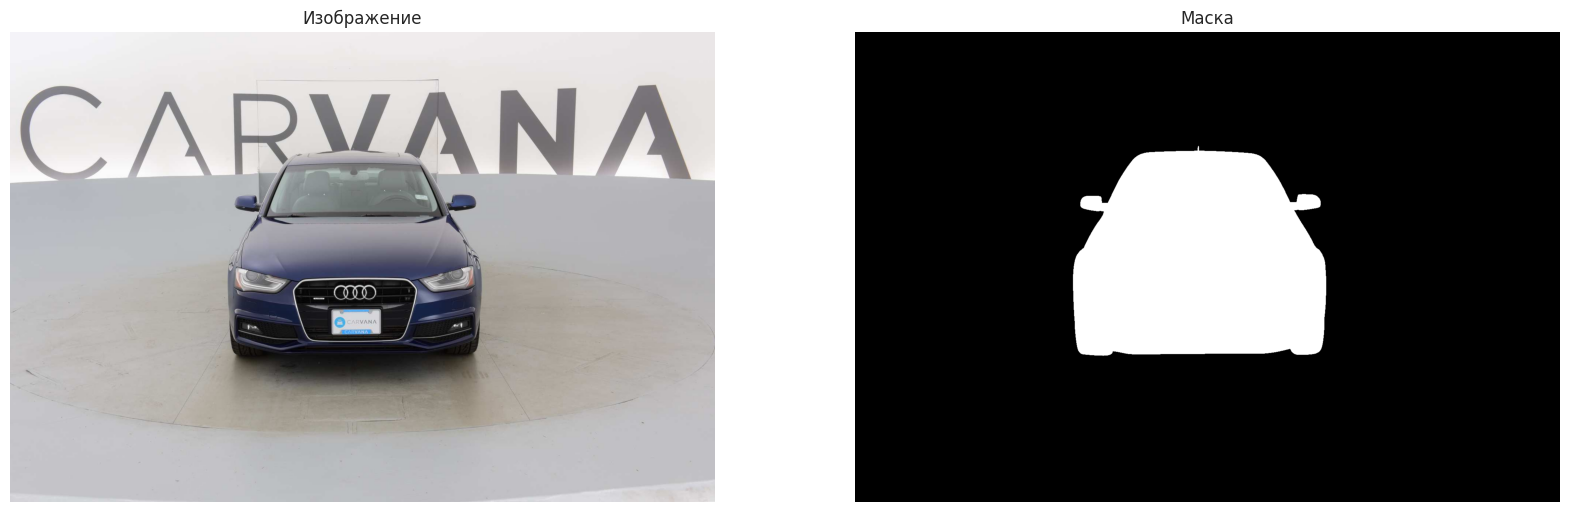

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))
plt.axis("off");

Исходные изображения довольно большие. Предлагаем вам работать с изображениями меньшего размера, а именно (160, 240) для уменьшения вычислительных затрат. Не забудьте сделать соответствующее преобразование.

In [10]:
Image.open(img_path).size

(1918, 1280)

In [11]:
mask = np.array(Image.open(mask_path))
np.unique(mask)

array([0, 1], dtype=uint8)

Как видим, маска состоит лишь из двух чисел -- 0 и 1.

### Задача 1. Простая сегментация
Вы построите свою собственную модель сегментации и проведете анализ ее работы.

#### 1. Обучение сегментации

Постройте модель типа U-Net. Вы можете использовать непосредственно первоначальную версию U-Net (рассматривали на лекции), либо ее модификацию, либо любую другую модель типа кодировщик-декодировщик с skip-connection конструкцией.

In [12]:
train_dir = DATA_PATH / "train"
train_mask_dir = DATA_PATH / "train_masks"

test_dir = DATA_PATH / "test"
test_mask_dir = DATA_PATH / "test_masks"

In [13]:
def get_file_names(image_dir, extension=None, suffix=None):
    files = sorted(image_dir.glob("*"))  # Сортируем все файлы в директории
    filtered_files = [
        file.name for file in files
        if (extension is None or file.suffix == f".{extension}") and
           (suffix is None or file.stem.endswith(suffix))
    ]
    return filtered_files

# Собираем названия файлов
train_files = get_file_names(train_dir, extension="jpg")  # JPG файлы
train_mask_files = get_file_names(train_mask_dir, extension="gif", suffix="_mask")  # GIF файлы с "_mask"

test_files = get_file_names(test_dir, extension="jpg")  # JPG файлы
test_mask_files = get_file_names(test_mask_dir, extension="gif", suffix="_mask")  # GIF файлы с "_mask"

# Проверяем результаты
print("Train files:", train_files[:5])  # Показать первые 5 названий
print("Train mask files:", train_mask_files[:5])
print("Test files:", test_files[:5])
print("Test mask files:", test_mask_files[:5])


Train files: ['00087a6bd4dc_01.jpg', '00087a6bd4dc_02.jpg', '00087a6bd4dc_03.jpg', '00087a6bd4dc_04.jpg', '00087a6bd4dc_05.jpg']
Train mask files: ['00087a6bd4dc_01_mask.gif', '00087a6bd4dc_02_mask.gif', '00087a6bd4dc_03_mask.gif', '00087a6bd4dc_04_mask.gif', '00087a6bd4dc_05_mask.gif']
Test files: ['00087a6bd4dc_15.jpg', '03a857ce842d_10.jpg', '03a857ce842d_13.jpg', '04bd942b463b_02.jpg', '04bd942b463b_09.jpg']
Test mask files: ['00087a6bd4dc_15_mask.gif', '03a857ce842d_10_mask.gif', '03a857ce842d_13_mask.gif', '04bd942b463b_02_mask.gif', '04bd942b463b_09_mask.gif']


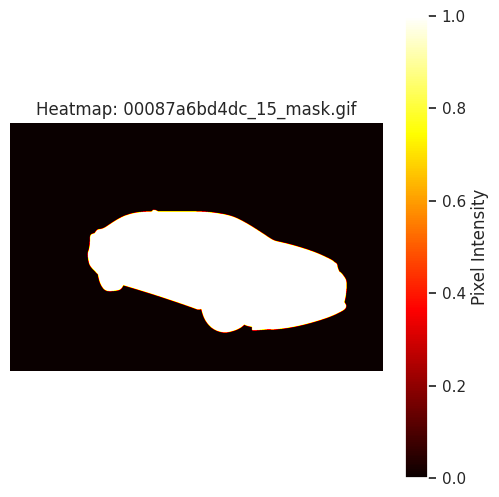

In [14]:
mask_path = test_mask_dir / test_mask_files[0]  
mask = Image.open(mask_path)  

mask_array = np.array(mask)

# Отображаем маску с помощью heatmap
plt.figure(figsize=(6, 6))
plt.title(f"Heatmap: {test_mask_files[0]}")
plt.imshow(mask_array, cmap="hot") 
plt.colorbar(label="Pixel Intensity")
plt.axis("off")
plt.show()

Будем использовать датасет с лекции

In [15]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        """
        Инициализация датасета. Задаем пути к изображениям и маскам, а также трансформации.
        :param images_filenames: Список имен файлов изображений.
        :param images_directory: Директория, где хранятся изображения.
        :param masks_directory: Директория, где хранятся маски.
        :param transform: Трансформации для аугментации изображений и масок.
        """
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def _get_image_mask(self, image_filename):
        """
        Получение изображения и соответствующей маски для заданного имени файла.
        :param image_filename: Имя файла изображения.
        :return: Кортеж (image, mask).
        """
        # Считываем изображение
        image_path = os.path.join(self.images_directory, image_filename)
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found: {image_path}")

        # Считываем маску (имя маски отличается расширением и суффиксом '_mask')
        mask_filename = image_filename.replace(".jpg", "_mask.gif")
        mask_path = os.path.join(self.masks_directory, mask_filename)
        try:
            mask = Image.open(mask_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        return image, mask

    def __getitem__(self, idx):
        """
        Получение изображения и маски по индексу.
        :param idx: Индекс.
        :return: Кортеж (image, mask), где оба объекта могут быть преобразованы через transform.
        """
        # print(self.images_filenames)
        image_filename = self.images_filenames[idx]
        image, mask = self._get_image_mask(image_filename)

        # Применяем трансформацию (аугментацию), если задана
        if self.transform is not None:
            # Преобразуем изображения и маски в numpy для совместимости с albumentations
            image_np = np.array(image)
            mask_np = np.array(mask)
            transformed = self.transform(image=image_np, mask=mask_np)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

Наконец получим наши датасеты, с учетом небольшой агументации.

In [16]:
train_transform = A.Compose(
    [
        A.Resize(160, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.GaussNoise(),
        ToTensorV2()
    ]
)
val_transform = A.Compose([
    A.Resize(160, 256),
    ToTensorV2()
])
train_dataset = OxfordPetDataset(train_files, train_dir, train_mask_dir, transform=train_transform)
val_dataset = OxfordPetDataset(test_files, test_dir, test_mask_dir, transform=val_transform)


Посмотрим на результат аугментации

In [17]:
def visualize_augmentations(dataset, idx=0, samples=5):
    '''Визуализируем samples аугментаций для индекса idx из dataset'''
    # Делаем копию датасета для визуализации
    dataset = copy.deepcopy(dataset)

    # Убираем из аугментаций нормализацию и приведение к тензору, для удобства отображения результата
    dataset.transform = A.Compose([
        t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])

    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(5, 13))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

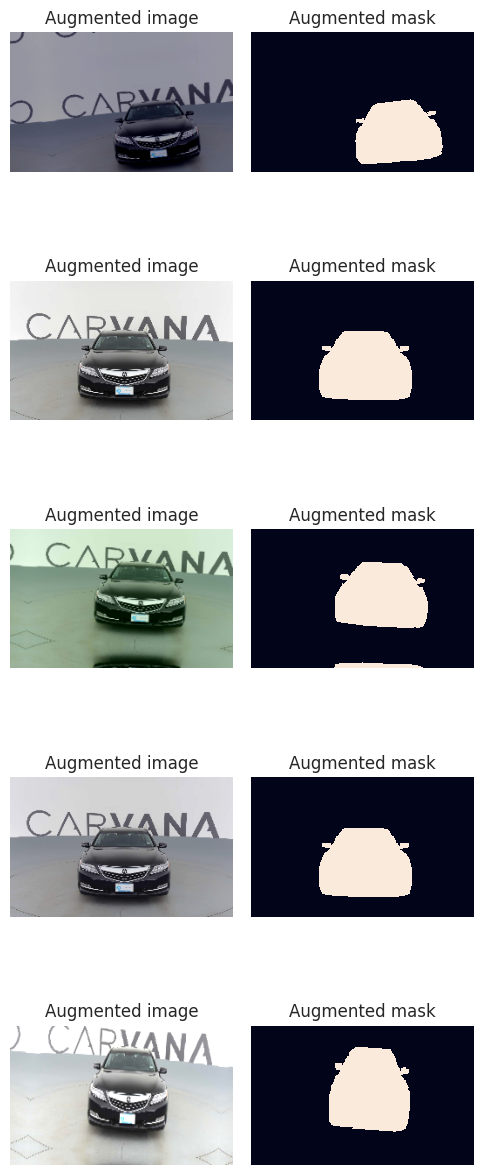

In [18]:
visualize_augmentations(train_dataset, idx=0, samples=5)



Получим dataloader-ы.

In [19]:
batch_size = 32
num_workers = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers)

In [20]:
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    """
    Рассчитывает метрику IoU (Intersection over Union).
    :param pred_mask: Тензор с предсказаниями (Batch, 1, H, W).
    :param true_mask: Тензор с истинными метками (Batch, 1, H, W).
    :param threshold: Порог для бинаризации предсказания.
    :return: IoU для текущего батча.
    """
    pred_mask = torch.sigmoid(pred_mask)  # Преобразуем в вероятности
    pred_mask = (pred_mask > threshold).float()  # Бинаризуем предсказания

    # Вычисляем пересечение и объединение
    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum(pred_mask) + torch.sum(true_mask) - intersection

    # Возвращаем IoU
    return intersection / union if union > 0 else torch.tensor(0.0)

Реализуем класс U-net соответсвующий оригинальной статье.

In [21]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        """
        Инициализация модели U-Net.
        :param in_channels: Количество входных каналов (например, 3 для RGB изображений).
        :param out_channels: Количество выходных каналов (например, 1 для бинарной сегментации).
        """
        super(UNet, self).__init__()

        # Этапы энкодера
        self.encoder1 = self.encoder_block(in_channels, 64)
        self.encoder2 = self.encoder_block(64, 128)
        self.encoder3 = self.encoder_block(128, 256)
        self.encoder4 = self.encoder_block(256, 512)

        # Базовый слой (bottleneck)
        self.bottleneck = self.baseline_layer(512, 1024)

        # Этапы декодера
        self.decoder1 = self.decoder_block(1024 + 512, 512)
        self.decoder2 = self.decoder_block(512 + 256, 256)
        self.decoder3 = self.decoder_block(256 + 128, 128)
        self.decoder4 = self.decoder_block(128 + 64, 64)

        # Финальный слой
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def encoder_block(self, in_channels, out_channels):
        """Блок энкодера: два сверточных слоя + макспулинг"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def baseline_layer(self, in_channels, out_channels):
        """Базовый слой (bottleneck): два сверточных слоя"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def decoder_block(self, in_channels, out_channels):
        """Блок декодера: транспонированная свертка + два сверточных слоя"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Энкодер
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        # Базовый слой (bottleneck)
        bottleneck = self.bottleneck(enc4)

        # Декодер
        dec4 = self.decoder1(torch.cat([bottleneck, enc4], dim=1))
        dec3 = self.decoder2(torch.cat([dec4, enc3], dim=1))
        dec2 = self.decoder3(torch.cat([dec3, enc2], dim=1))
        dec1 = self.decoder4(torch.cat([dec2, enc1], dim=1))

        # Финальный выход
        return self.final_conv(dec1)


In [22]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, model = UNet(in_channels=3, out_channels=1), loss = nn.BCEWithLogitsLoss(), lr=1e-4):
        """
        Инициализация модели сегментации.
        :param encoder_name: Архитектура энкодера, поддерживаемая segmentation_models_pytorch.
        :param encoder_weights: Предобученные веса энкодера ('imagenet', None).
        :param lr: Скорость обучения.
        """
        super().__init__()
        self.lr = lr
        self.criterion = loss
        self.save_hyperparameters()

        self.model = model
        self.predictions = []

    def configure_optimizers(self):
        """Настройка оптимизатора."""
        return optim.Adam(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        """
        Прямой проход через модель.
        :param x: Входные изображения.
        :return: Предсказанные маски.
        """
        output = self.model(x)  
        return output

    def __step(self, batch):
        """
        Выполнение одного шага (обучения или валидации).
        :param batch: Батч данных (изображения, целевые маски).
        :return: Значение функции потерь и IoU.
        """
        images, target = batch

        # Приводим изображения и маски к типу float32
        images = images.float()
        
        # Добавляем канал к целевой маске
        if target.dim() == 3:
            target = target.unsqueeze(1)

        target = target.float()

        output = self.forward(images)
            
        loss = self.criterion(output, target)

        # Вычисление IoU
        iou = calculate_iou(output, target)

        return loss, iou

    def training_step(self, batch, batch_idx):
        """Шаг обучения."""
        loss, iou = self.__step(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_iou", iou, prog_bar=True)
        wandb.log({"train_loss": loss, "train_iou": iou})
        return loss

    def validation_step(self, batch, batch_idx):
        """Шаг валидации."""
        loss, iou = self.__step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_iou", iou, prog_bar=True)
        wandb.log({"val_loss": loss, "val_iou": iou})
        return loss

    def test_step(self, batch, batch_idx):
        """
        Шаг тестирования. Сохраняет предсказанные маски.
        :param batch: Батч данных (изображения, исходные размеры масок).
        """
        images, (original_heights, original_widths) = batch
        output = self.forward(images)
        probabilities = torch.sigmoid(output)
        predicted_masks = (probabilities >= 0.5).float()
        predicted_masks = predicted_masks.cpu().numpy()
        for predicted_mask, original_height, original_width in zip(
            predicted_masks, original_heights.cpu().numpy(), original_widths.cpu().numpy()
        ):
            self.predictions.append((predicted_mask, original_height, original_width))


Обучите модель на тренировочной части данных. В качестве метрики качества используйте IoU. Визуализируйте изменение ошибки (loss) и метрики (IoU) на тренировочной и тестовой части данных.

Создадим модель, checkpointer и trainer.

In [23]:
wandb_logger = WandbLogger(
    project="task_12_1",
    name="UNet-carvana_dataset",
    log_model="all"                  
)

# Создание модели и тренера
model = SegmentationModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",  # Отслеживаем метрику для сохранения лучших чекпоинтов
    mode="min",          # Минимизируем значение метрики
    save_top_k=1,        # Сохраняем только лучший чекпоинт
    filename="{epoch:02d}-{val_loss:.4f}"  # Шаблон имени файла
)

# Инициализация тренера с WandB логгером
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    logger=wandb_logger  
)

trainer.fit(model, train_loader, val_loader)

wandb.finish()

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
wandb: Currently logged in as: demoren (demoren_mipt). Use `wandb login --relogin` to force relogin


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Визуализируем результаты

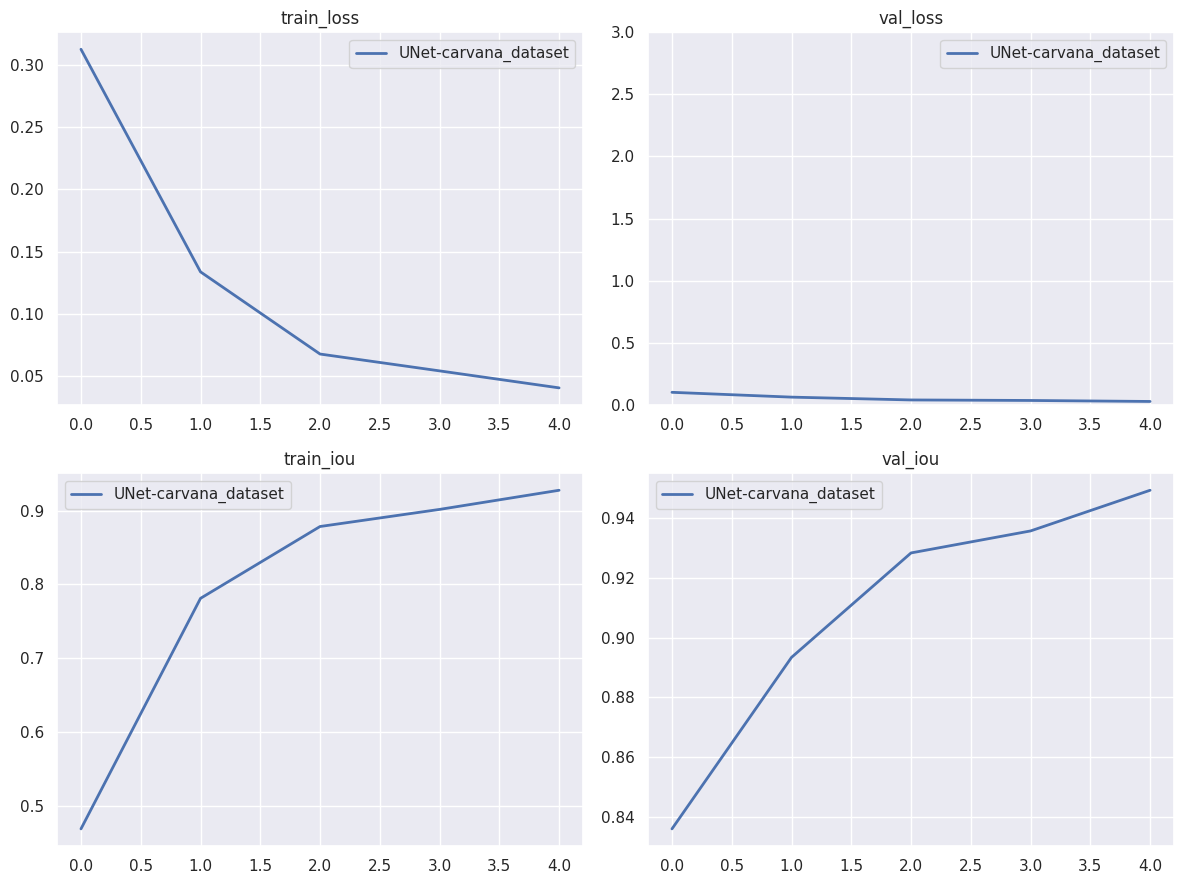

In [24]:
runs = wandb.Api().runs("task_12_1")
subplot_names = np.array([['train_loss', 'val_loss'],
                          ['train_iou', 'val_iou']])
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()
    axs[0, 1].set_ylim((0, 3))
plt.tight_layout()

Как быстро обучается модель? Как вы думаете, с чем это связано?

**Ответ:** Модель обучается достаточно долго, что не удивительно, мы имеем порядка 5000 фотографий 160*256, таким образом даже имея одино полносвязный слой модель имеет достаточно большое количество параметров.

#### 2. Анализ модели
Выберите 10 изображений из тестовой части данных и посчитайте качество модели на них. Теперь поменяйте фон для изображений. Можно, например, поменять его цвет. Проверьте качество модели на новых изображениях.

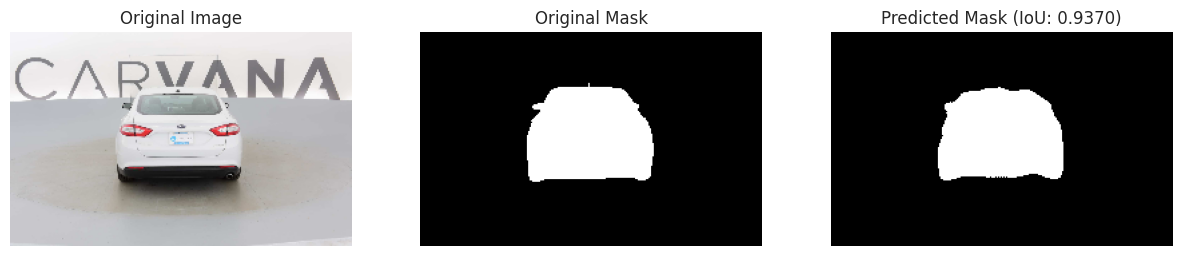

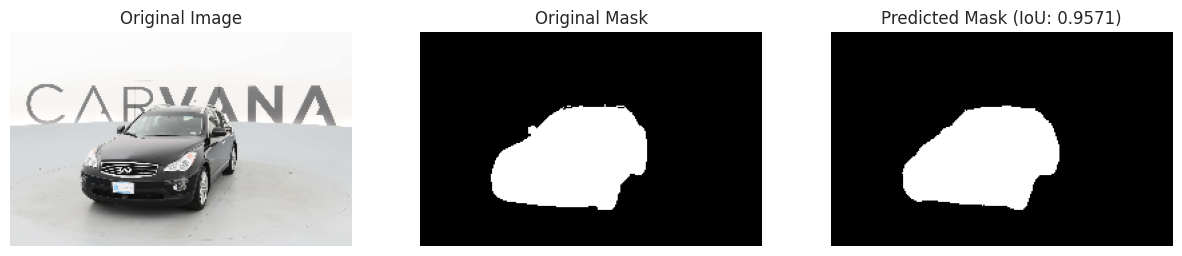

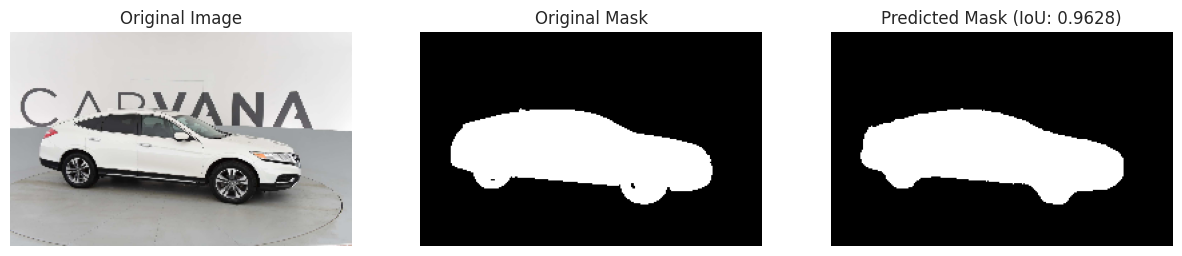

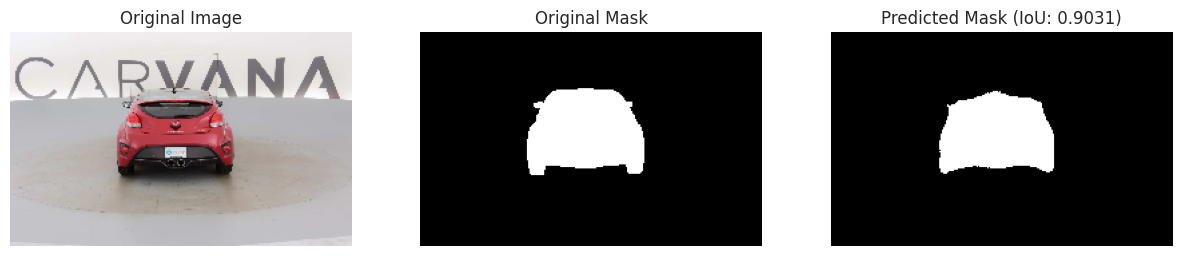

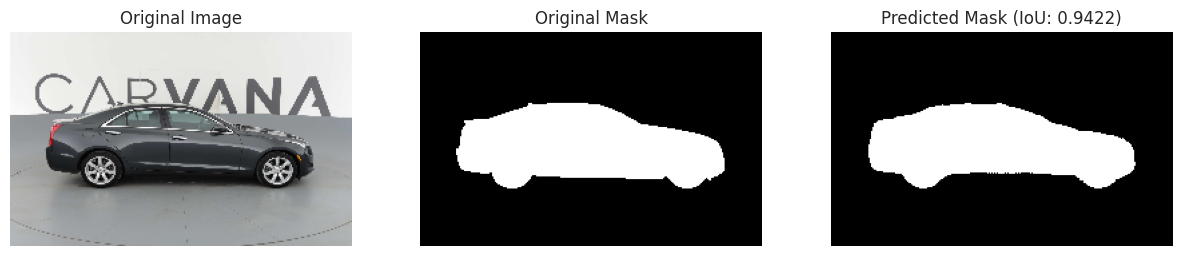

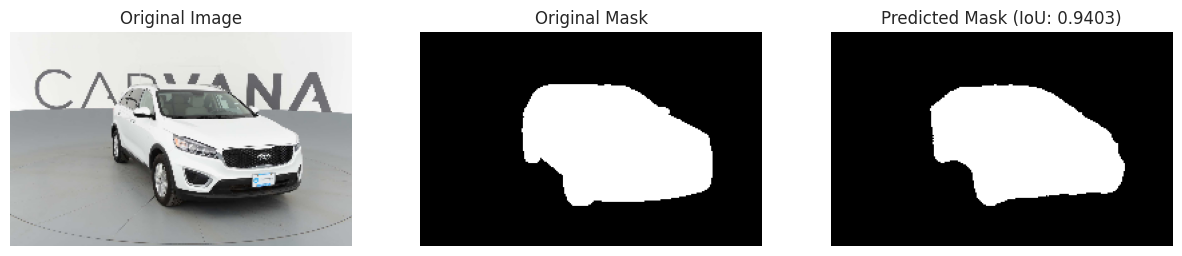

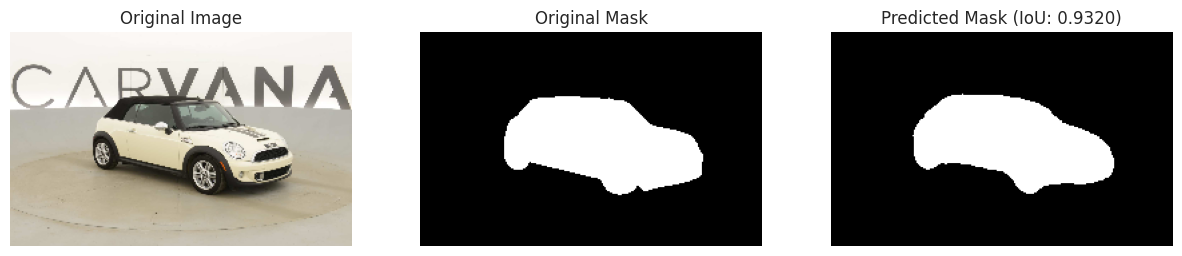

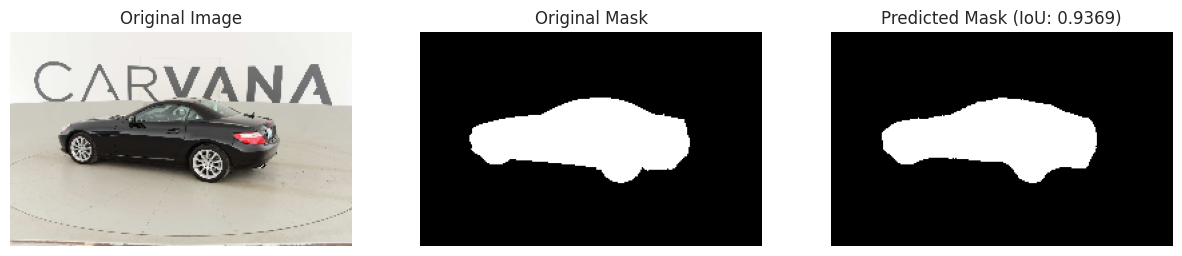

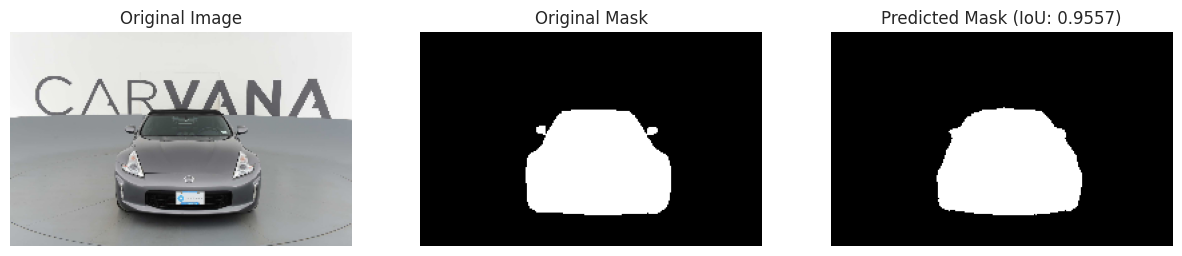

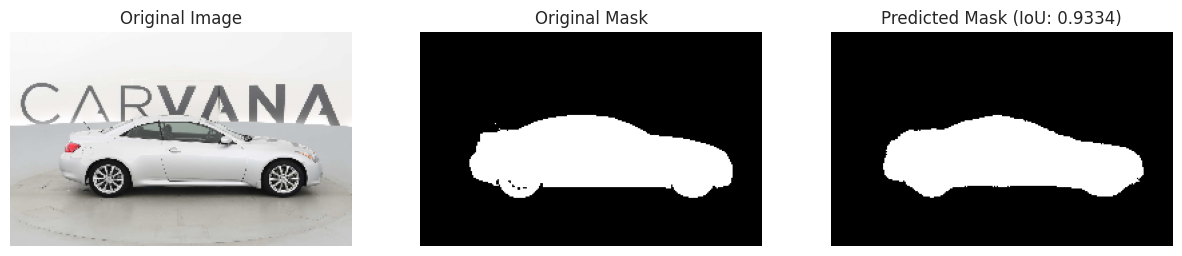

Средний IoU: 0.9400


0.9400452

In [25]:
def evaluate_model_on_images(model, images, masks, device):
    ious = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for image, mask in zip(images, masks):
            image = image.unsqueeze(0).to(device)  # Добавляем размерность батча и перемещаем на GPU
            mask = mask.unsqueeze(0).to(device)  # Перемещаем маску на GPU

            # Прогоняем изображение через модель
            output = model(image.float())
            
            if isinstance(output, dict) and 'out' in output:
                output = output['out']
            
            output = torch.sigmoid(output)  # Применяем сигмоиду для получения вероятностей
            pred_mask = (output >= 0.5).cpu().squeeze()  # Преобразуем в бинарную маску

            # Преобразуем маску в numpy и вычисляем IoU
            mask = mask.cpu().squeeze()
            iou = calculate_iou(pred_mask, mask)
            ious.append(iou)

            # Визуализация оригинального изображения, маски и предсказания
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
            # Отображаем оригинальное изображение
            ax[0].imshow(image.cpu().squeeze().permute(1, 2, 0))
            ax[0].set_title("Original Image")
            ax[0].axis('off')

            # Отображаем оригинальную маску
            ax[1].imshow(mask, cmap='gray')
            ax[1].set_title("Original Mask")
            ax[1].axis('off')

            # Отображаем предсказанную маску
            ax[2].imshow(pred_mask, cmap='gray')
            ax[2].set_title(f"Predicted Mask (IoU: {iou:.4f})")
            ax[2].axis('off')

            plt.show()

    mean_iou = np.mean(ious)
    print(f"Средний IoU: {mean_iou:.4f}")
    return mean_iou


test_indices = random.sample(range(len(val_loader.dataset)), 10)
images = [val_loader.dataset[idx][0] for idx in test_indices]
masks = [val_loader.dataset[idx][1] for idx in test_indices]

evaluate_model_on_images(model, images, masks, device='cuda')

Заменим фон, и еще раз пересчитаем качество модели

In [26]:
def change_background(image, mask, new_color=(53, 128, 213)):
    image_np = image.numpy().transpose(1, 2, 0)  # Преобразуем в HWC формат
    background = np.full(image_np.shape, new_color, dtype=np.uint8)
    new_image = np.where(mask.numpy()[:, :, np.newaxis] == 1, image_np, background)
    return new_image

# Используем list comprehension для изменения фона всех изображений
new_images_list = [change_background(*val_loader.dataset[idx]) for idx in test_indices]

# Преобразуем список новых изображений в тензор
# Преобразуем в формат [N, C, H, W] для корректного отображения
new_images = torch.tensor(np.array(new_images_list)).permute(0, 3, 1, 2)  # [N, C, H, W]

# Проверяем размерность
print(new_images.shape)

torch.Size([10, 3, 160, 256])


Попробуем снова применить нашу модель на полученных изображениях

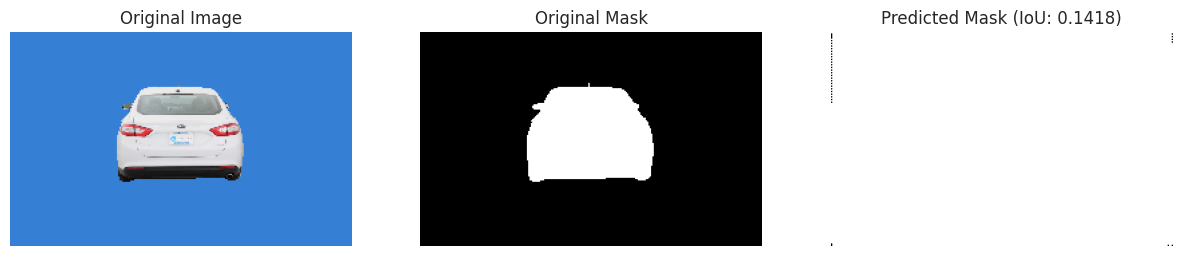

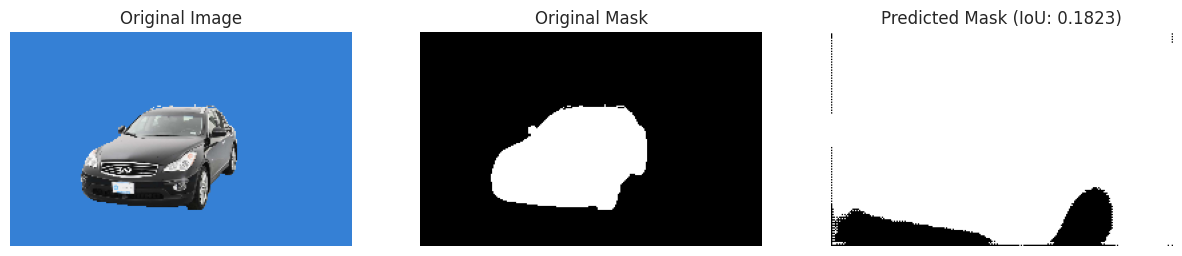

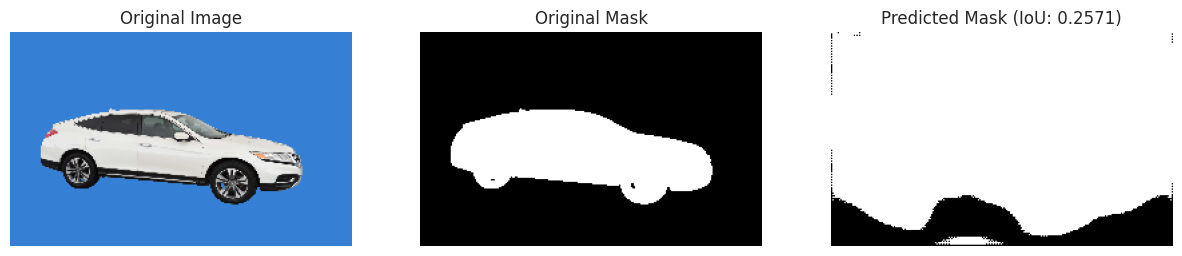

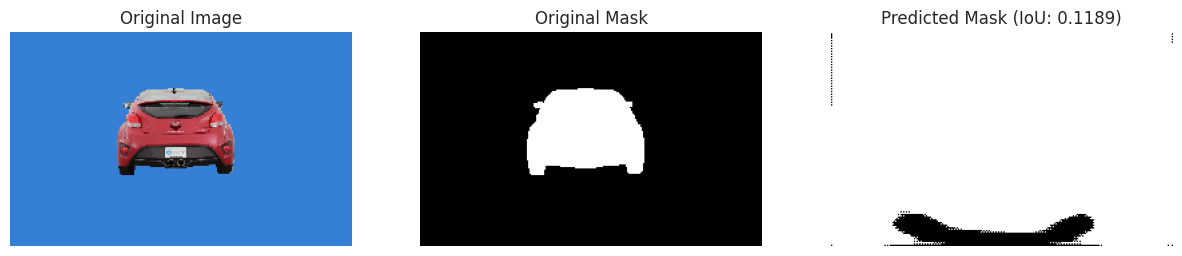

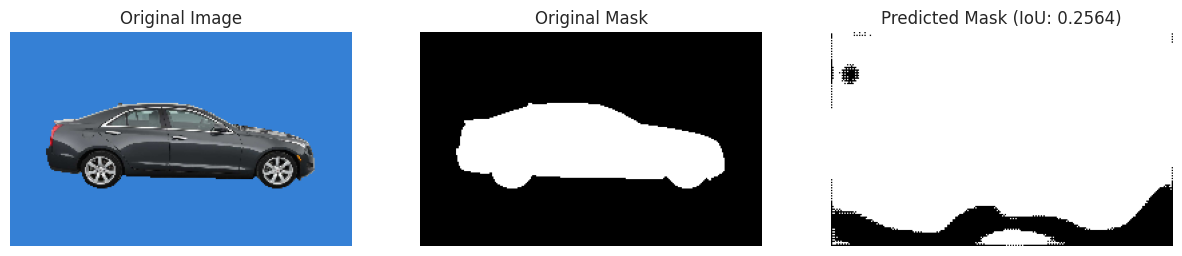

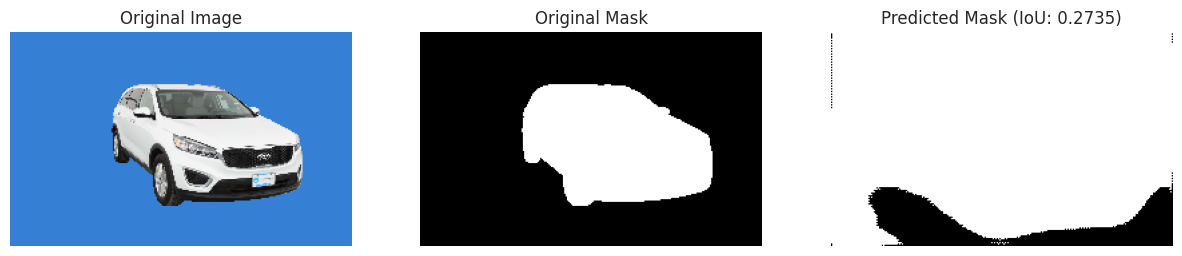

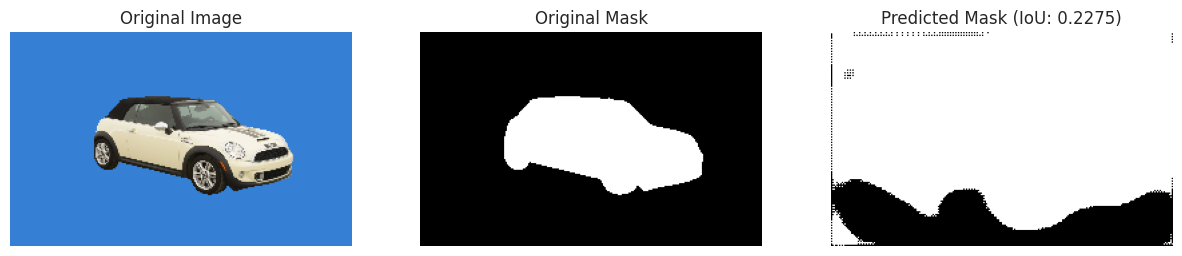

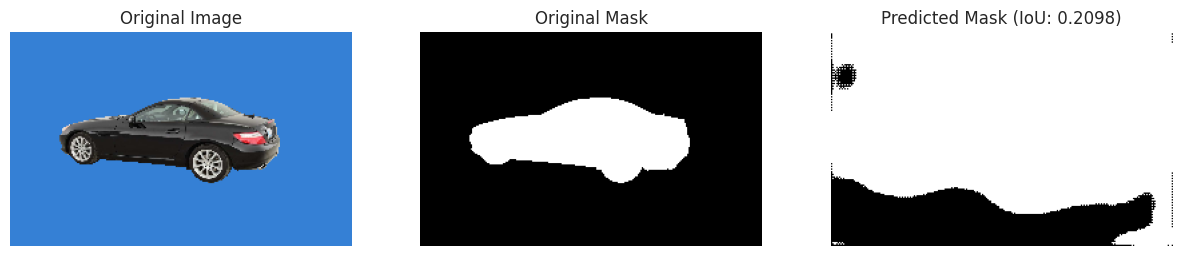

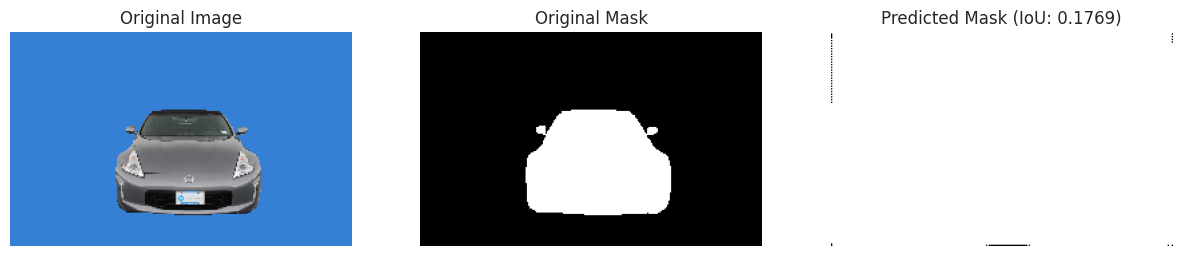

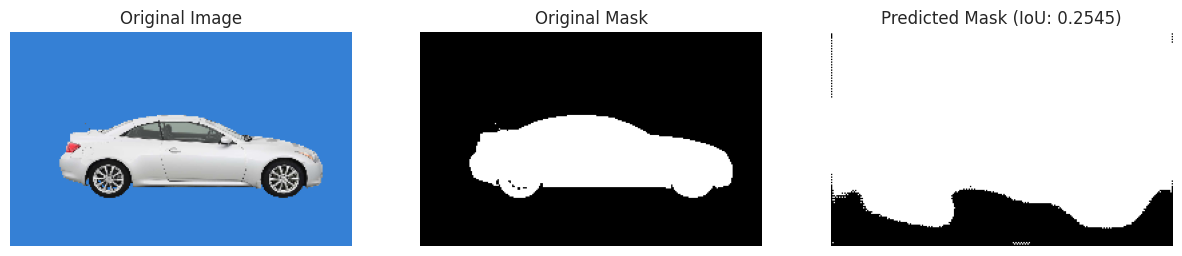

Средний IoU: 0.2099


0.20986474

In [27]:
evaluate_model_on_images(model, new_images, masks, device="cuda")

Ответьте на вопрос, модель научилась сегментировать машины или фон?

**Ответ:** Как видим модель научилась сегментировать скорее фон чем машины, что не удивительно, все фото были сделаны на одном фоне.

**Вывод:** В данной задаче мы при помощи модели U-net смогли с достаточно высоким качеством сегментировать автомобили. Тем не менее при замене фона оказалось, что наша модель сегментирует скорее фон чем автомобили, что вызвано однообразием фотографий.

### Задача 2. Сравнение лоссов сегментации
Будем работать с датасетом [CityScapes](https://www.cityscapes-dataset.com/). Этот датасет состоит из кадров съемки автомобиля, движущегося по улицам  Германии. Проверим, насколько хорошо с ним справляются предобученные модели со структурой, отличной от U-Net. Скачайте [архив](https://disk.yandex.ru/d/J8gPv_bEiK-_QQ) с данными с диска. В папках `images` и `masks` лежат изображения и маски автомобилей соответственно.


In [28]:
DATA_PATH_CITY = Path("/kaggle/input/cityscapes/cityscapes")


In [29]:
# Задаем директории
root_directory = os.path.join(DATA_PATH_CITY)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "masks")

image_files = sorted([f for f in os.listdir(images_directory) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(masks_directory) if f.endswith('.png')])

train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

Определите датасет для CityScapes и даталоадеры.

In [30]:
class CityscapesDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        """
        Инициализация датасета. Задаем пути к изображениям и маскам, а также трансформации.
        :param images_filenames: Список имен файлов изображений.
        :param images_directory: Директория, где хранятся изображения.
        :param masks_directory: Директория, где хранятся маски.
        :param transform: Трансформации для аугментации изображений и масок.
        """
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def _get_image_mask(self, image_filename):
        """
        Получение изображения и соответствующей маски для заданного имени файла.
        :param image_filename: Имя файла изображения.
        :return: Кортеж (image, mask).
        """
        # Считываем изображение
        image_path = os.path.join(self.images_directory, image_filename)
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found: {image_path}")

        # Считываем маску (имя маски отличается расширением и суффиксом '_mask')
        mask_filename = image_filename.replace(".png", "_mask.png")  # Используем расширение .png для маски
        mask_path = os.path.join(self.masks_directory, mask_filename)
        try:
            mask = Image.open(mask_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        return image, mask

    def __getitem__(self, idx):
        """
        Получение изображения и маски по индексу.
        :param idx: Индекс.
        :return: Кортеж (image, mask), где оба объекта могут быть преобразованы через transform.
        """
        image_filename = self.images_filenames[idx]
        image, mask = self._get_image_mask(image_filename)

        # Преобразуем в numpy массивы с типом данных uint8
        image_np = np.array(image, dtype=np.uint8)
        mask_np = np.array(mask, dtype=np.uint8)

        # Применяем трансформацию (аугментацию), если задана
        if self.transform is not None:
            transformed = self.transform(image=image_np, mask=mask_np)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask


In [31]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.GaussNoise(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = CityscapesDataset(train_images, images_directory, masks_directory, transform=train_transform)
val_dataset = CityscapesDataset(val_images, images_directory, masks_directory, transform=val_transform)

batch_size = 32
num_workers = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers)

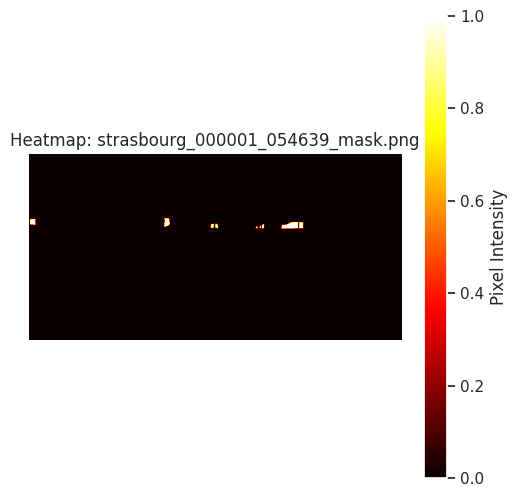

array([0, 1])

In [32]:
mask_path = masks_directory + '/' + train_masks[0]  
mask = Image.open(mask_path)  

mask_array = np.array(mask).astype(np.int64)

# Отображаем маску с помощью heatmap
plt.figure(figsize=(6, 6))
plt.title(f"Heatmap: {train_masks[0]}")
plt.imshow(mask_array, cmap="hot") 
plt.colorbar(label="Pixel Intensity")
plt.axis("off")
plt.show()

np.unique(mask_array)

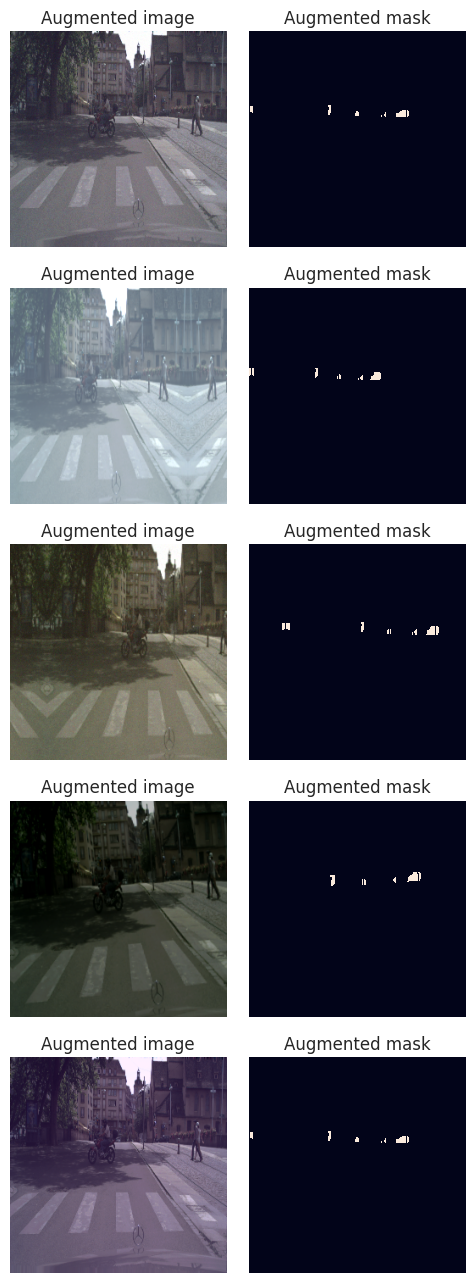

In [33]:
visualize_augmentations(train_dataset, idx=0, samples=5)

Определите класс модуля lightning для обучения модели сегментации машин. В качестве модели используйте предобученную `fcn_resnet50` или `deeplabv3_resnet50` из `torchvision.models.segmentation` на ваш выбор. Особенностью их использования является то, что модели дают на выходе маски для 21 класса (как в COCO) в поле `out` (см. примеры в семинаре). В остальном модели не отличаются от тех, что мы использовали ранее.

Наша цель - сравнить работу 3 лоссов - Binary Cross Entropy, Dice Loss, Tversky Loss. Реализацию двух последних можно взять из библиотеки [monai](https://docs.monai.io/en/stable/losses.html).

В качестве метрики используйте IoU.

Будем использовать fcn_resnet50

In [34]:
def calculate_iou_multiclass(pred_mask, true_mask, num_classes=21):
    ious = []
    for i in range(num_classes):
        # Преобразуем в тензоры PyTorch перед выполнением операций
        pred = ((pred_mask == i).clone().detach()).float()
        true = ((true_mask == i).clone().detach()).float()
        
        intersection = torch.sum(pred * true)
        union = torch.sum(pred) + torch.sum(true) - intersection
        iou = intersection / union if union > 0 else torch.tensor(0.0)
        ious.append(iou.item())
    return np.mean(ious)


def denormalize_image(image, mean, std, device):
    image = image.to("cpu") * std.view(-1, 1, 1).to("cpu") + mean.view(-1, 1, 1).to("cpu")
    image = image.clamp(0, 1)  # Ограничиваем значения в диапазоне [0, 1]
    image = (image * 255).byte()  # Преобразуем в диапазон [0, 255]
    return image
    

def evaluate_model_on_images_multiclass(model, images, masks, device):
    ious = []

    model.to(device)
    model.eval()

    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    with torch.no_grad():
        for image, mask in zip(images, masks):
            image = image.unsqueeze(0).to(device)  # Добавляем размерность батча и перемещаем на GPU
            mask = mask.unsqueeze(0).to(device)  # Перемещаем маску на GPU
            
            output = model.forward_all_classes(image.float())
            
            if isinstance(output, dict) and 'out' in output:
                output = output['out']
            
            output = torch.softmax(output, dim=1)  
            
            pred_mask = (output.argmax(dim=1) == 7).cpu().squeeze()  # Сравниваем с классом 7
            pred_mask_image = output[0, 7].cpu().squeeze()
            
            mask = mask.cpu().squeeze()
            iou = calculate_iou_multiclass(pred_mask, mask.int(), 2)
            ious.append(iou)

            image_denorm = denormalize_image(image.cpu().squeeze(), mean, std, device)
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
            ax[0].imshow(image_denorm.permute(1, 2, 0))  # Преобразуем из (C, H, W) в (H, W, C)
            ax[0].set_title("Original Image")
            ax[0].axis('off')

            ax[1].imshow(mask, cmap='gray')
            ax[1].set_title("Original Mask")
            ax[1].axis('off')

            pred_image = ax[2].imshow(pred_mask_image, cmap='gray')
            ax[2].set_title(f"Predicted Mask (IoU: {iou:.4f})")
            ax[2].axis('off')
            fig.colorbar(pred_image, ax=ax[2], fraction=0.03, pad=0.04)

            plt.show()

    mean_iou = np.mean(ious)
    print(f"Средний IoU: {mean_iou:.4f}")
    return mean_iou

In [35]:
class SegmentationModelMulticanal(pl.LightningModule):
    def __init__(self, model, loss, lr=1e-4):
        '''Инициализация модели'''
        super().__init__()
        self.lr = lr
        self.criterion = loss
        self.save_hyperparameters()
        self.model = model
        self.predictions = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward_all_classes(self, x):
        '''Предсказание для всех 21 канала'''
        return self.model(x)['out']  # (BS, 21, H, W)

    def forward(self, x):
        '''Предсказание только для автомобиля (канал 7)'''
        return self.forward_all_classes(x)[:, 7]  # (BS, H, W)

    def __step(self, batch):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        images, target = batch
        output = self.forward(images)

        # Убедимся, что целевая метка имеет тип float
        target = target.float()  # Преобразуем target в тип float

        loss = self.criterion(output, target)

        # Преобразуем предсказания и цели в бинарные маски
        pred_mask = (torch.sigmoid(output) >= 0.5).float()
        target_mask = (target >= 0.5).float()

        # Вычисление IoU
        iou = calculate_iou_multiclass(pred_mask, target_mask.int(), 2)

        return loss, iou

    def training_step(self, batch, batch_idx):
        '''Шаг обучения'''
        loss, iou = self.__step(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_iou", iou, prog_bar=True)
        wandb.log({"train_loss": loss, "train_iou": iou})  # Логирование в WandB
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        '''Шаг валидации'''
        loss, iou = self.__step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_iou", iou, prog_bar=True)
        wandb.log({"val_loss": loss, "val_iou": iou})  # Логирование в WandB
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        '''Сохраняет предсказанную маску сегментации в self.predictions и логирует результат'''
        images, (original_heights, original_widths) = batch
        output = self.forward(images)
        probabilities = torch.sigmoid(output)
        predicted_masks = (probabilities >= 0.5).float()
        predicted_masks = predicted_masks.cpu().numpy()

        # Логируем некоторое количество предсказанных масок
        if batch_idx % 10 == 0:  # Логируем каждую 10-ю итерацию
            self.log("test_sample", batch_idx, prog_bar=True)
            wandb.log({"test_sample": batch_idx})

        for predicted_mask, original_height, original_width in zip(
            predicted_masks, original_heights.cpu().numpy(), original_widths.cpu().numpy()
        ):
            self.predictions.append((predicted_mask, original_height, original_width))

        # Для логирования IoU для теста, можем использовать предсказанные маски и целевые
        true_mask = batch[1].float()  # Предположим, что целевая маска в batch[1]
        iou = calculate_iou(predicted_masks[0], true_mask[0])  # Пример для 1-го примера из батча
        self.log("test_iou", iou, prog_bar=True)
        wandb.log({"test_iou": iou})

In [36]:
from torchvision.models.segmentation import fcn_resnet50

model = SegmentationModelMulticanal(model = fcn_resnet50(weights='DEFAULT'), loss = nn.BCEWithLogitsLoss)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 87.5MB/s] 
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


#### Визуализация до обучения

До обучения визуализируйте несколько предсказаний модели на тестовой части CityScapes. Покажите исходную картинку, предсказание модели и истинную маску. Не забудьте брать предсказания только по каналу машин.

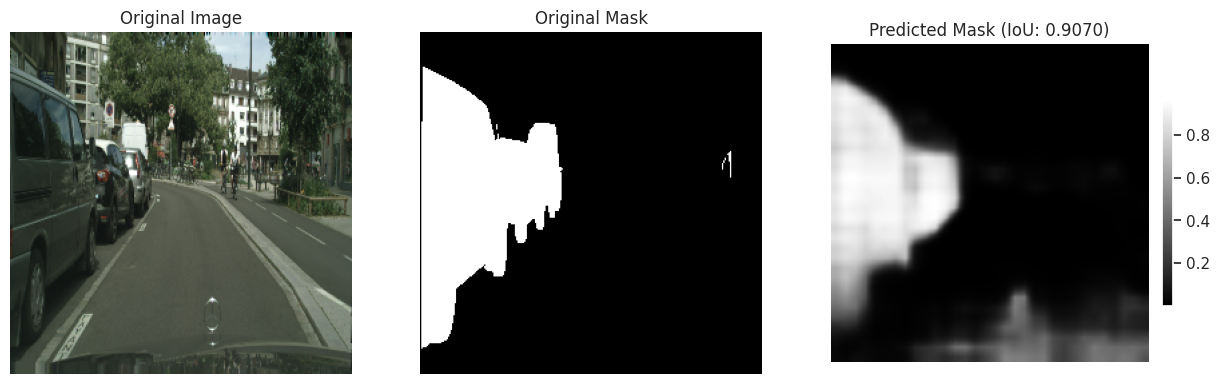

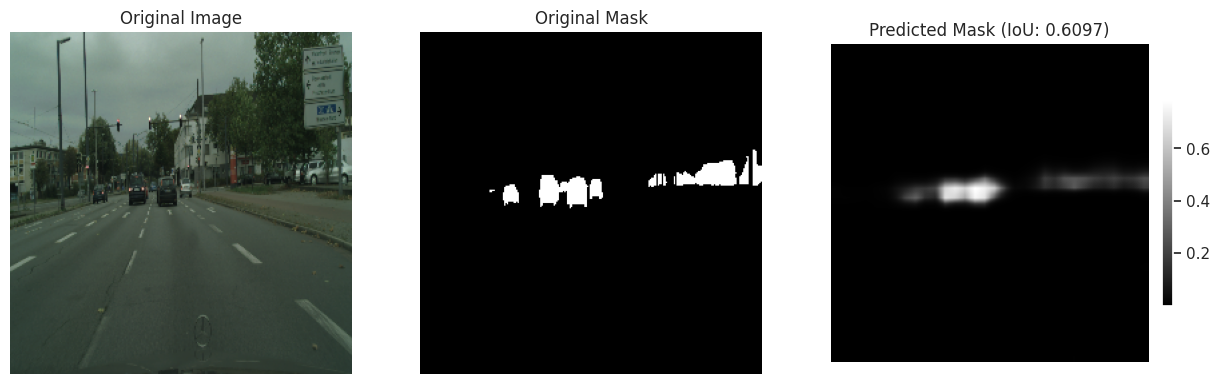

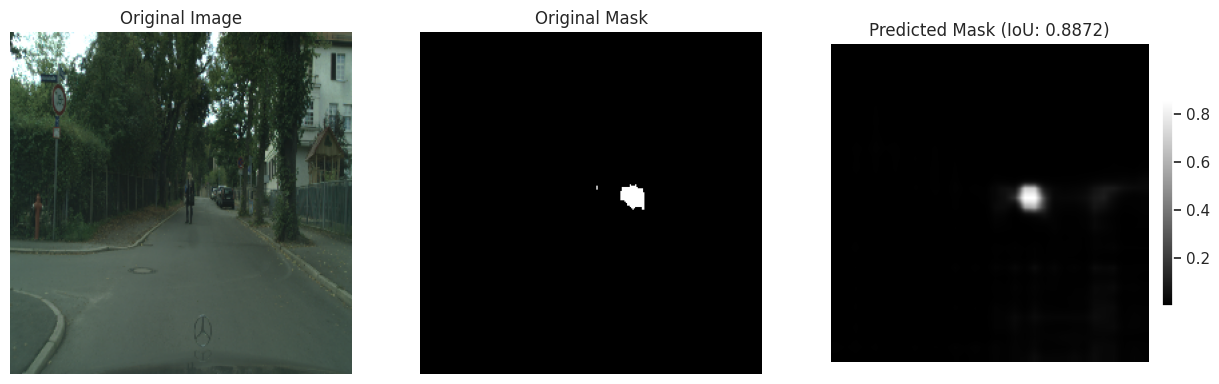

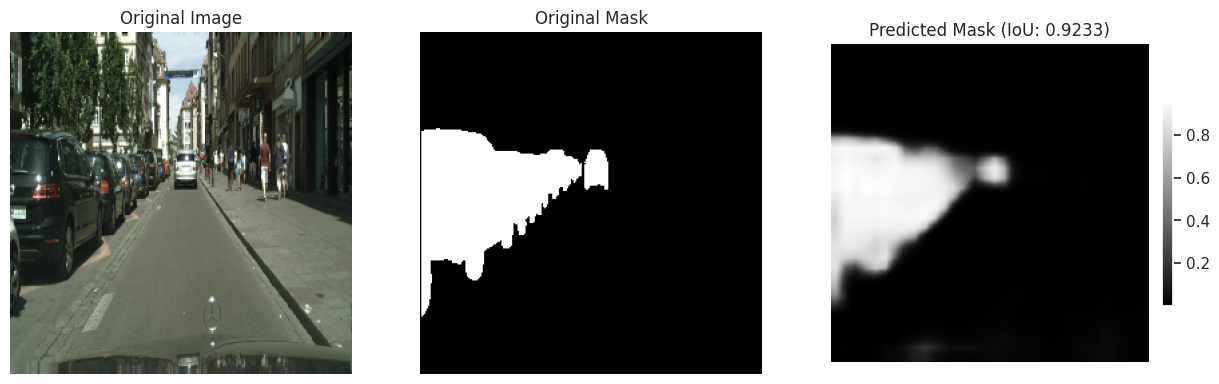

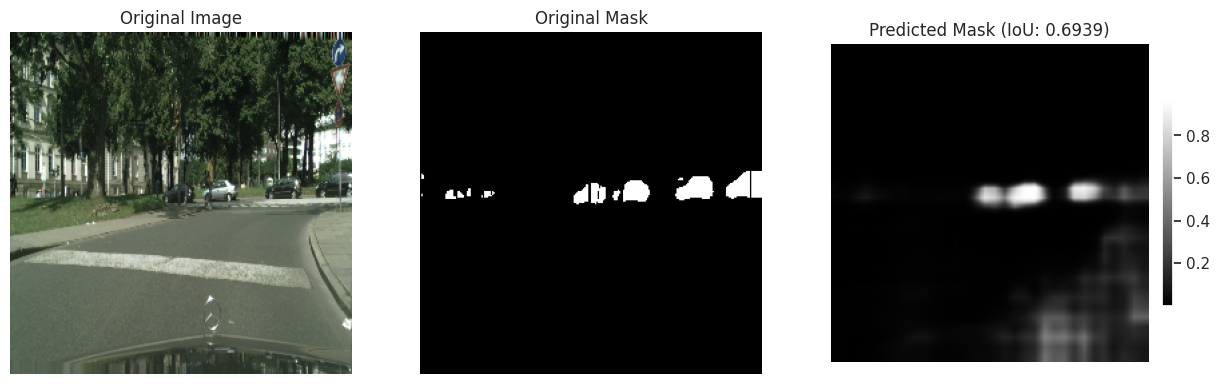

Средний IoU: 0.8042


In [37]:
test_indices = random.sample(range(len(val_loader.dataset)), 5)
images = [val_loader.dataset[idx][0] for idx in test_indices]
masks = [val_loader.dataset[idx][1] for idx in test_indices]

evaluate_model_on_images_multiclass(model, images, masks, device='cuda');

#### Binary Cross Entropy

Обучите предобученную модель, используя BCE Loss. Сравните несколько предсказаний с истинными масками на тестовой выборке. Также после обучения (до завершения wandb run) выведите IoU на тесте с помощью `trainer.validate`.

In [38]:
binary_model = SegmentationModelMulticanal(model = fcn_resnet50(weights='DEFAULT'), loss = nn.BCEWithLogitsLoss())

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [39]:
wandb_logger = WandbLogger(
    project="task_12_2",
    name="fcn_resnet50_binary_loss",
    log_model="all"                  
)

# Создание модели и тренера
model = SegmentationModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",  # Отслеживаем метрику для сохранения лучших чекпоинтов
    mode="min",          # Минимизируем значение метрики
    save_top_k=1,        # Сохраняем только лучший чекпоинт
    filename="{epoch:02d}-{val_loss:.4f}"  # Шаблон имени файла
)

# Инициализация тренера с WandB логгером
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    logger=wandb_logger  
)

trainer.fit(binary_model, train_loader, val_loader)

val_results = trainer.validate(binary_model, val_loader)
print(f"Validation IoU: {val_results[0]['val_iou']}")

wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.8678818345069885     │
│         val_loss          │    0.07465735822916031    │
└───────────────────────────┴───────────────────────────┘

Validation IoU: 0.8678818345069885


Выведем полученные результаты

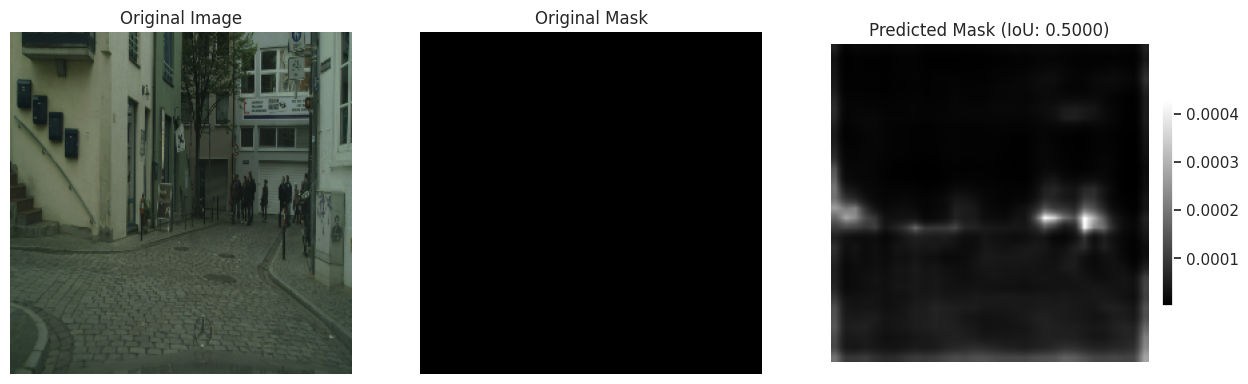

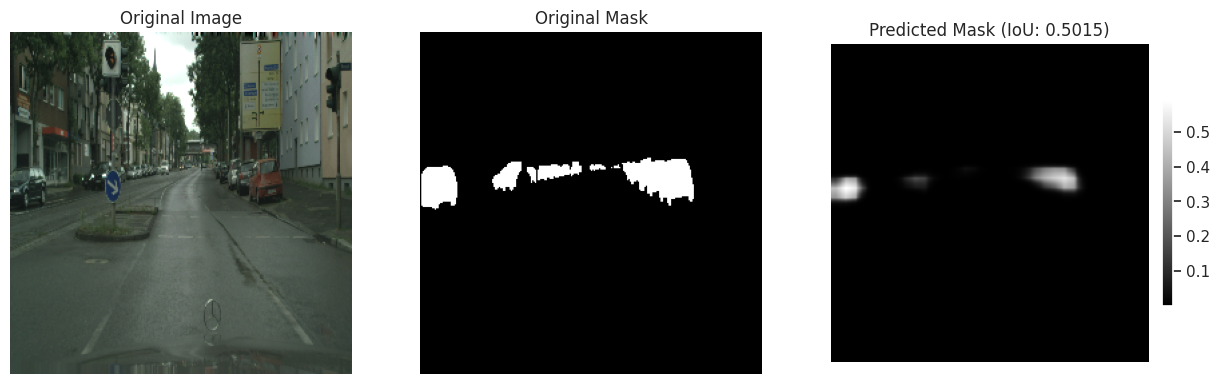

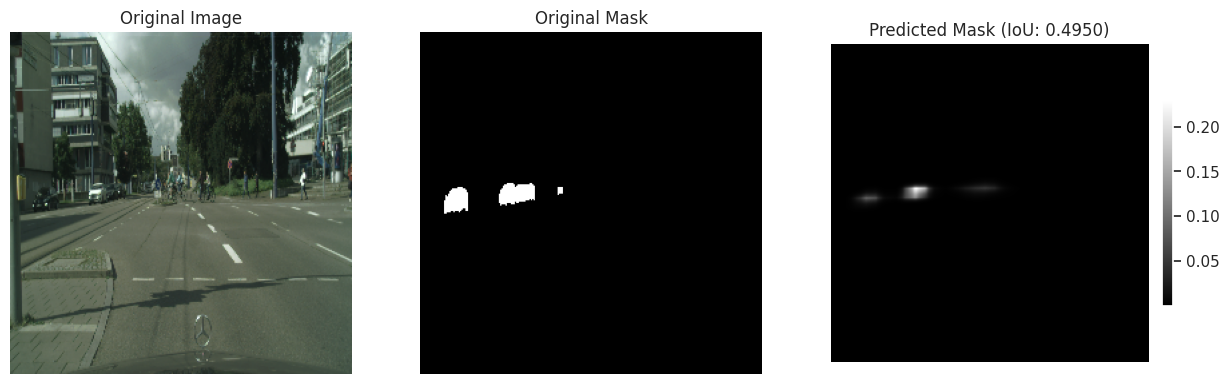

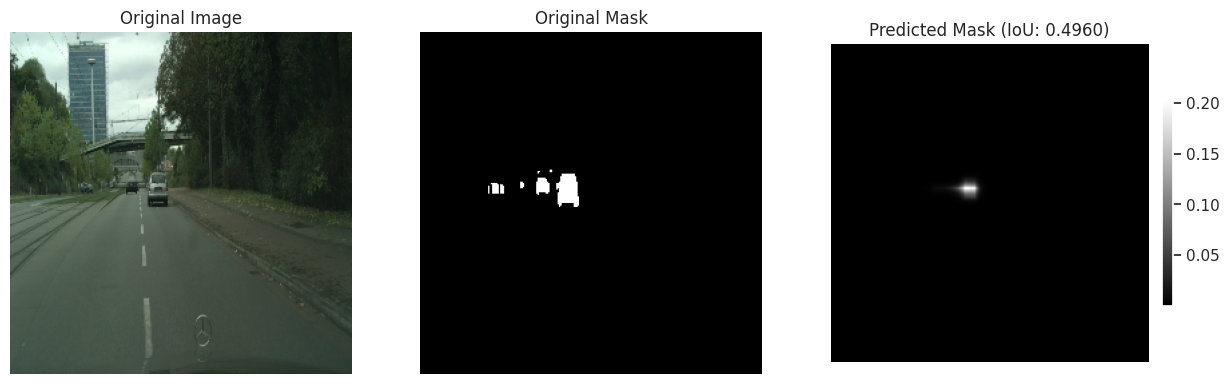

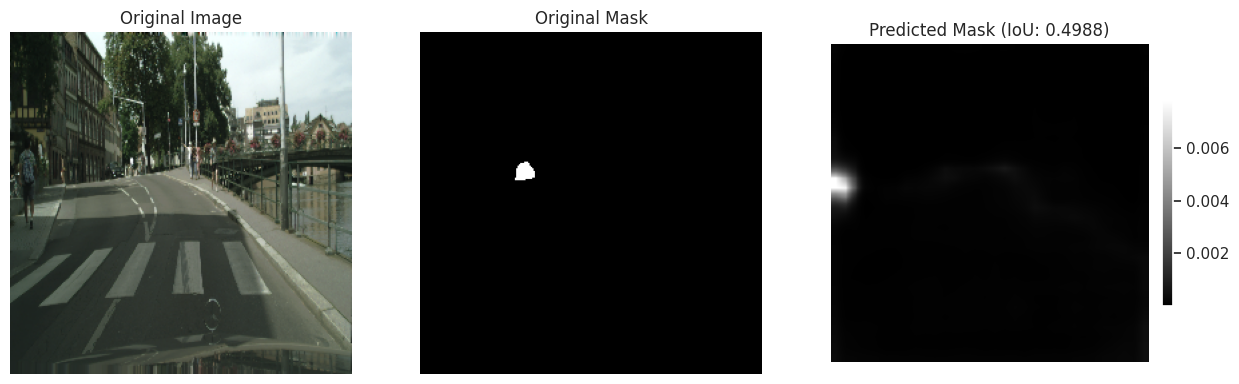

Средний IoU: 0.4983


In [40]:
test_indices = random.sample(range(len(val_loader.dataset)), 5)
images = [val_loader.dataset[idx][0] for idx in test_indices]
masks = [val_loader.dataset[idx][1] for idx in test_indices]

evaluate_model_on_images_multiclass(binary_model, images, masks, device='cuda');

#### Dice Loss

Сделайте то же самое для Dice Loss.

In [42]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.2 MB/s eta 0:00:00a 0:00:01


In [43]:
from monai.losses import DiceLoss

dice_loss_model = SegmentationModelMulticanal(model = fcn_resnet50(weights='DEFAULT'), loss = DiceLoss())

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [44]:
wandb_logger = WandbLogger(
    project="task_12_2",
    name="fcn_resnet50_dice_loss",
    log_model="all"                  
)

# Создание модели и тренера
model = SegmentationModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",  # Отслеживаем метрику для сохранения лучших чекпоинтов
    mode="min",          # Минимизируем значение метрики
    save_top_k=1,        # Сохраняем только лучший чекпоинт
    filename="{epoch:02d}-{val_loss:.4f}"  # Шаблон имени файла
)

# Инициализация тренера с WandB логгером
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    logger=wandb_logger  
)

trainer.fit(dice_loss_model, train_loader, val_loader)

val_results = trainer.validate(dice_loss_model, val_loader)
print(f"Validation IoU: {val_results[0]['val_iou']}")

wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.5089595317840576     │
│         val_loss          │    0.8924224376678467     │
└───────────────────────────┴───────────────────────────┘

Validation IoU: 0.5089595317840576


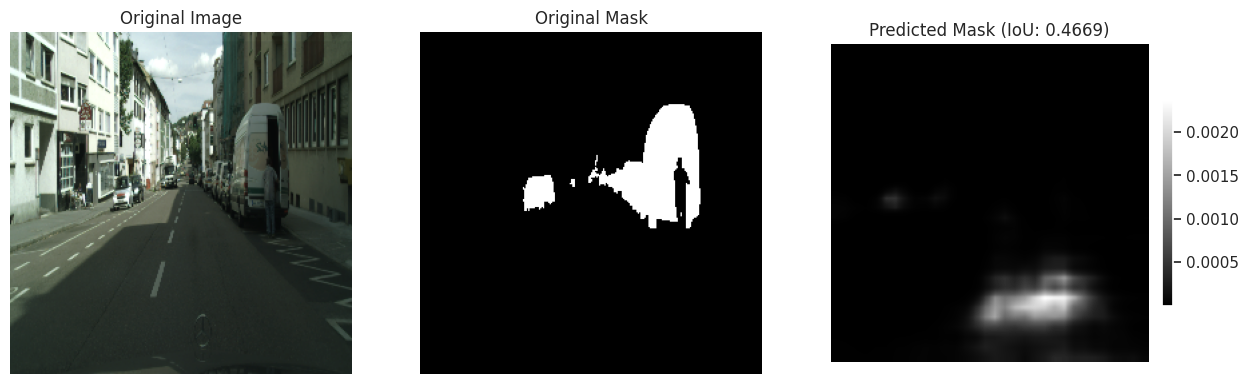

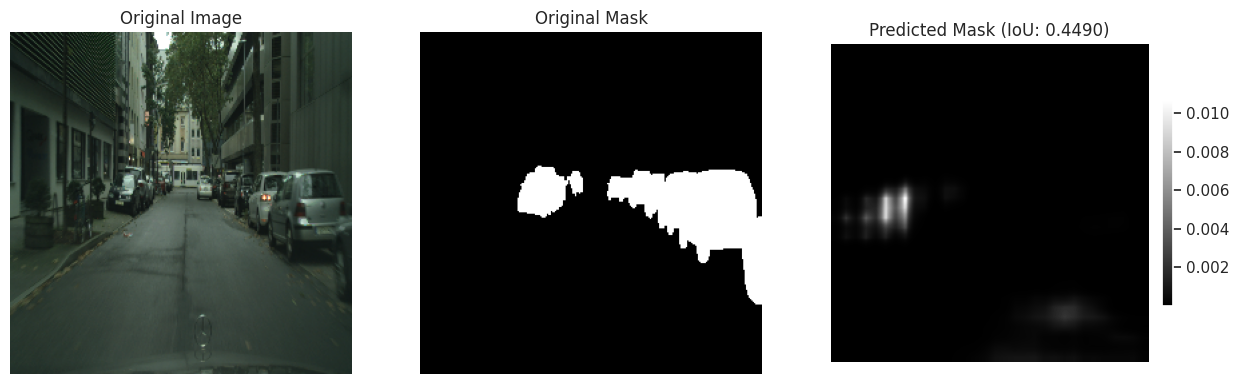

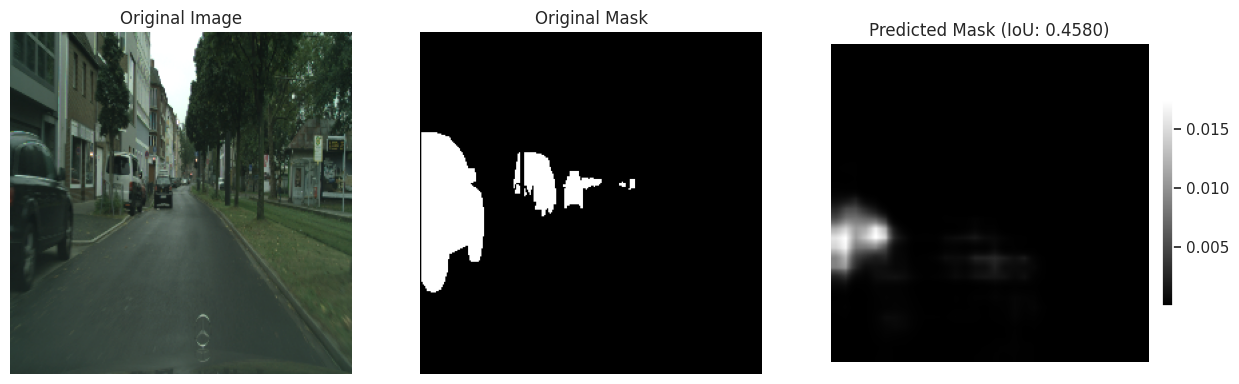

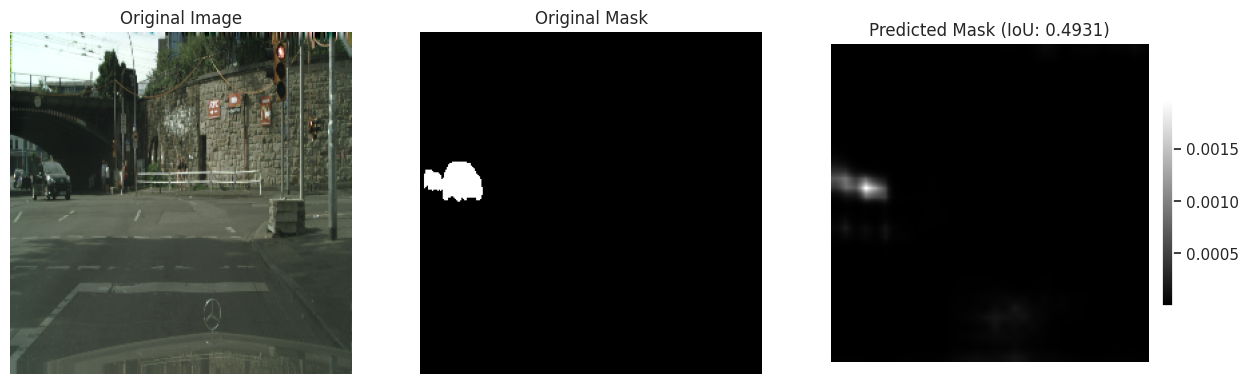

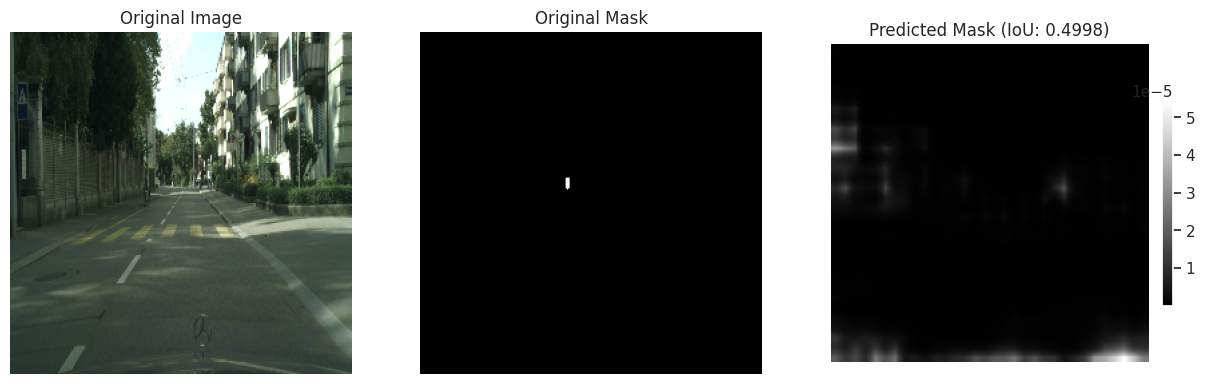

Средний IoU: 0.4734


In [45]:
test_indices = random.sample(range(len(val_loader.dataset)), 5)
images = [val_loader.dataset[idx][0] for idx in test_indices]
masks = [val_loader.dataset[idx][1] for idx in test_indices]

evaluate_model_on_images_multiclass(dice_loss_model, images, masks, device='cuda');

Судя по визуализации, чего больше у модели - False Negative или False Positive предсказаний?

Так как модель просто нигде не отличает автомобиль, то у модели больше FN.

#### Tversky Loss

Tversky Index является обобщением Dice Index для произвольных весов при FP и FN:

$$T_{\alpha, \beta} (y, \hat{y}) = \frac{\text{TP}}{\text{TP} + \alpha \ \text{FP} + \beta \ \text{FN}}$$

При этом $T_{\frac{1}{2}, \frac{1}{2}}$ соответсвует Dice Index; а $T_{1, 1} - $ Jaccard index (IoU).

Исходя из выводов про FN и FP подберите параметры $\alpha, \beta$ у Tversky Loss для модели. Обучите ее с таким лоссом. Улучшилась ли метрика? Как изменились предсказания визуально?

Так как FN значительно больше чем TP, та разумно это как то компенсировать. Возьмем например $\alpha = 0.31, \ \beta = 0.69$

In [86]:
from monai.losses import TverskyLoss

tversky_loss_model = SegmentationModelMulticanal(model = fcn_resnet50(weights='DEFAULT'), loss = TverskyLoss(alpha=0.31, beta=0.69))

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [87]:
wandb_logger = WandbLogger(
    project="task_12_2",
    name="fcn_resnet50_tversky_loss",
    log_model="all"                  
)

# Создание модели и тренера
model = SegmentationModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",  # Отслеживаем метрику для сохранения лучших чекпоинтов
    mode="min",          # Минимизируем значение метрики
    save_top_k=1,        # Сохраняем только лучший чекпоинт
    filename="{epoch:02d}-{val_loss:.4f}"  # Шаблон имени файла
)

# Инициализация тренера с WandB логгером
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    logger=wandb_logger  
)

trainer.fit(tversky_loss_model, train_loader, val_loader)

val_results = trainer.validate(tversky_loss_model, val_loader)
print(f"Validation IoU: {val_results[0]['val_iou']}")

wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.5098358392715454     │
│         val_loss          │     0.831890881061554     │
└───────────────────────────┴───────────────────────────┘

Validation IoU: 0.5098358392715454


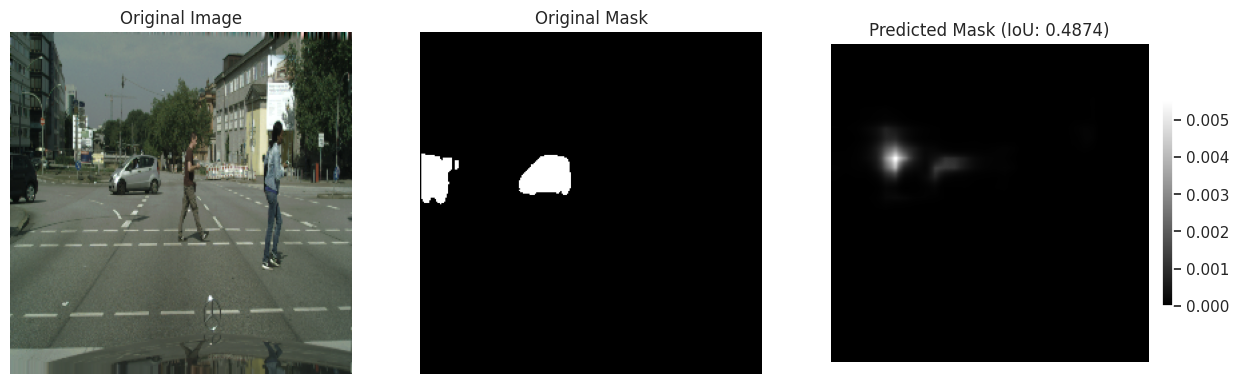

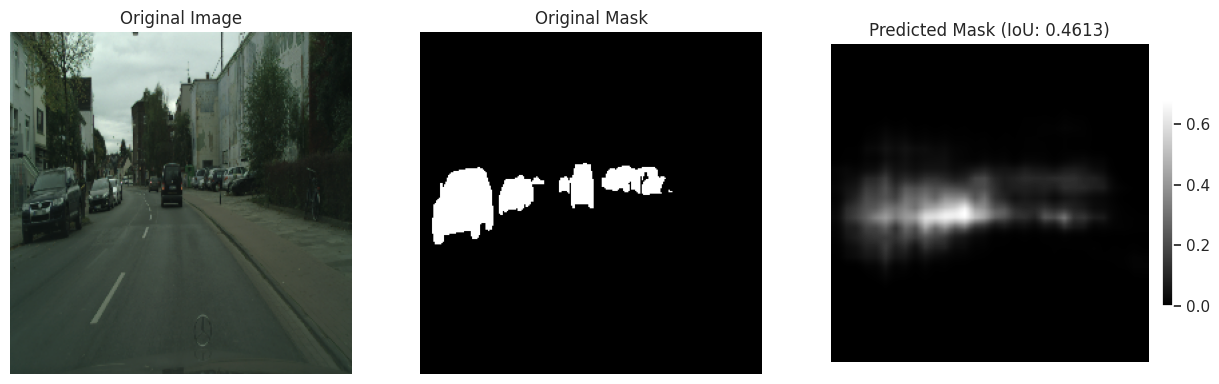

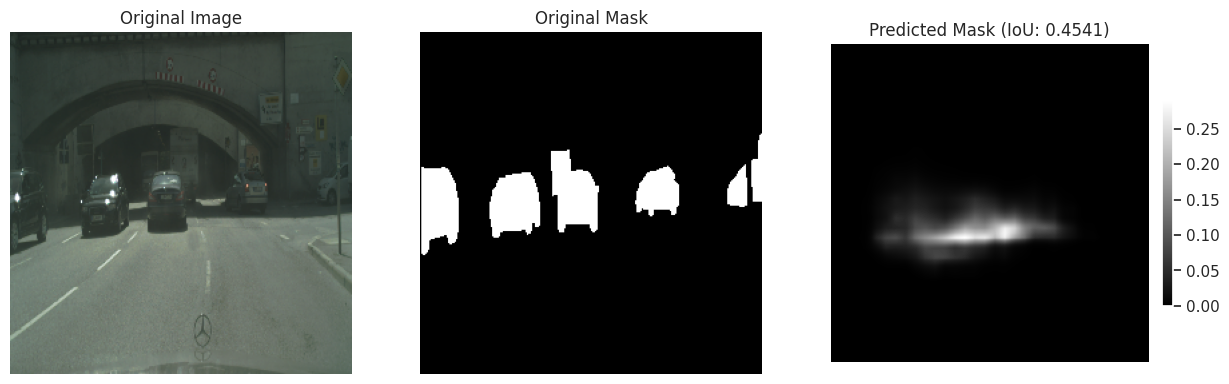

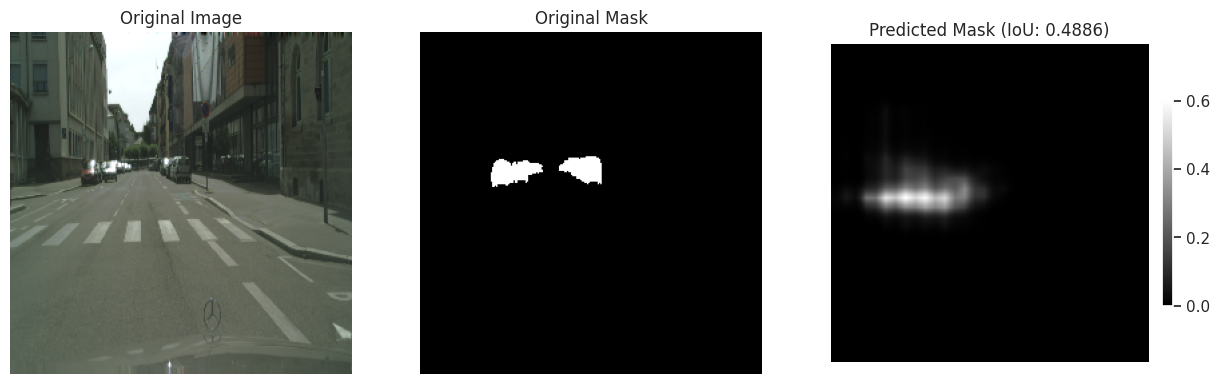

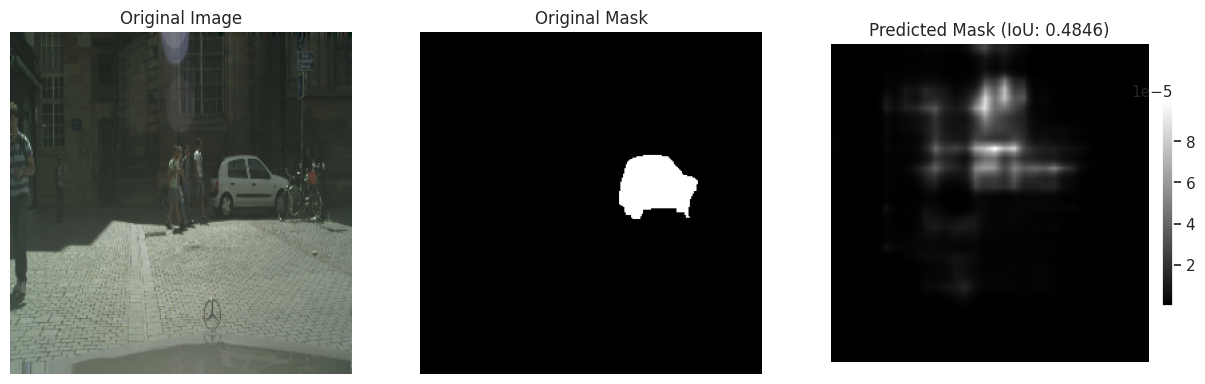

Средний IoU: 0.4752


In [88]:
test_indices = random.sample(range(len(val_loader.dataset)), 5)
images = [val_loader.dataset[idx][0] for idx in test_indices]
masks = [val_loader.dataset[idx][1] for idx in test_indices]

evaluate_model_on_images_multiclass(tversky_loss_model, images, masks, device='cuda');

Как видим, использование TverskyLoss не улучшило, но и не ухудшило результат.

#### Визуализация логов обучения

Визуализируйте лосс и метрику на обучении и валидации на предыдущих запусках. Сравните и сделайте выводы, а также выводы по всей задаче.

wandb не хочет отображать графики для train, так что их пришлось приложить скрином

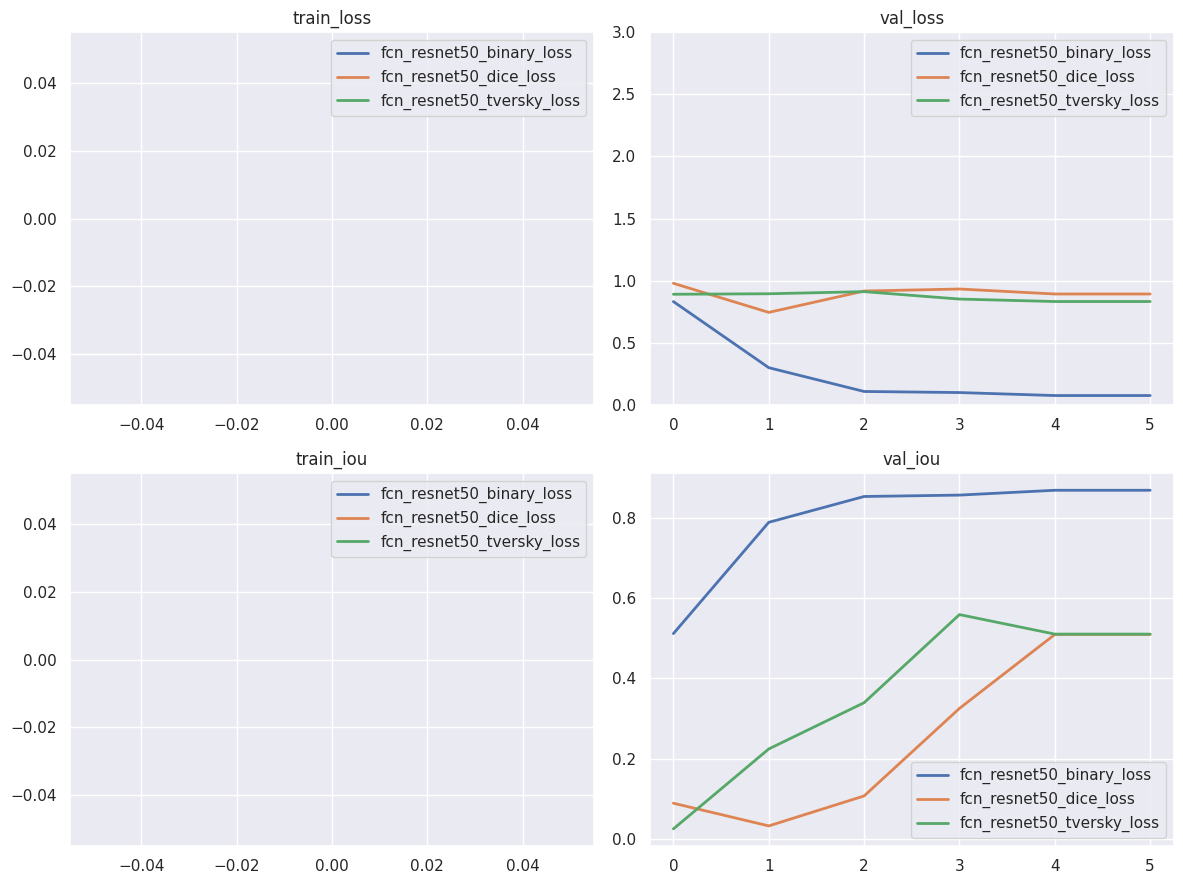

In [89]:
runs = wandb.Api().runs("task_12_2")
subplot_names = np.array([['train_loss', 'val_loss'],
                          ['train_iou', 'val_iou']])
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()
    axs[0, 1].set_ylim((0, 3))
plt.tight_layout()

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
train_loss = pd.read_csv("loss.csv")
train_iou = pd.read_csv("iou.csv")

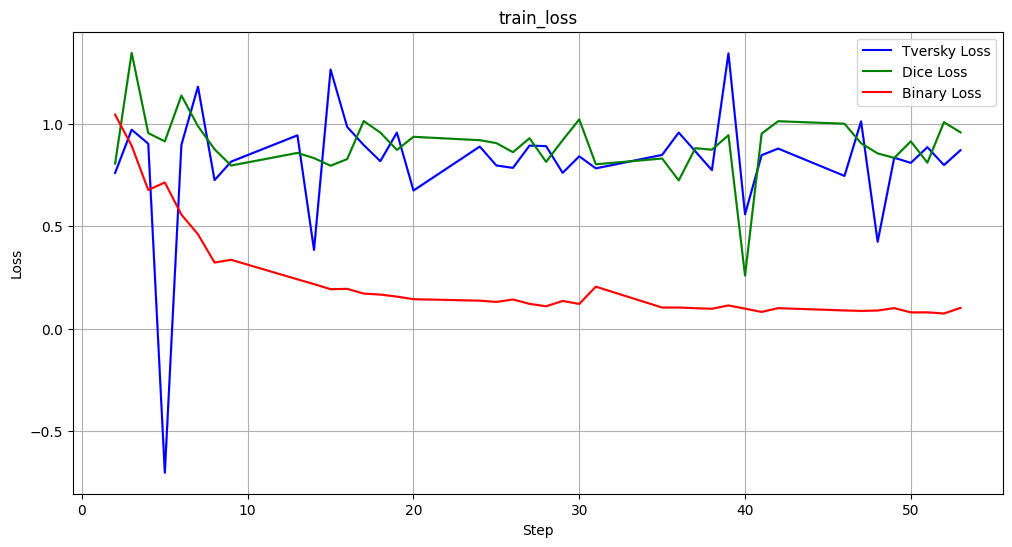

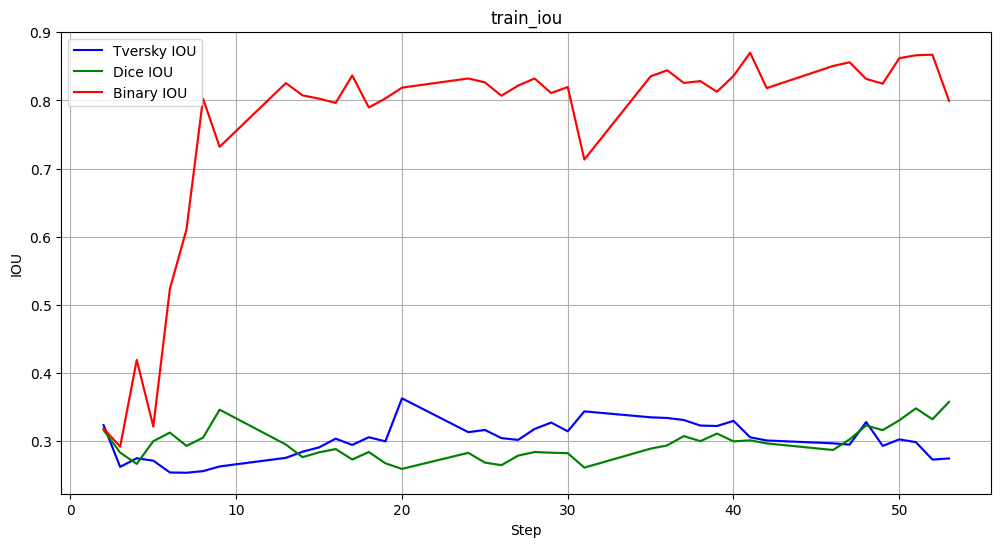

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(train_loss['Step'], train_loss['fcn_resnet50_tversky_loss - train_loss'], label='Tversky Loss', color='b')
plt.fill_between(train_loss['Step'], 
                 train_loss['fcn_resnet50_tversky_loss - train_loss__MIN'], 
                 train_loss['fcn_resnet50_tversky_loss - train_loss__MAX'], 
                 color='b', alpha=0.2)

plt.plot(train_loss['Step'], train_loss['fcn_resnet50_dice_loss - train_loss'], label='Dice Loss', color='g')
plt.fill_between(train_loss['Step'], 
                 train_loss['fcn_resnet50_dice_loss - train_loss__MIN'], 
                 train_loss['fcn_resnet50_dice_loss - train_loss__MAX'], 
                 color='g', alpha=0.2)

plt.plot(train_loss['Step'], train_loss['fcn_resnet50_binary_loss - train_loss'], label='Binary Loss', color='r')
plt.fill_between(train_loss['Step'], 
                 train_loss['fcn_resnet50_binary_loss - train_loss__MIN'], 
                 train_loss['fcn_resnet50_binary_loss - train_loss__MAX'], 
                 color='r', alpha=0.2)

plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('train_loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))

plt.plot(train_iou['Step'], train_iou['fcn_resnet50_tversky_loss - train_iou'], label='Tversky IOU', color='b')
plt.fill_between(train_iou['Step'], 
                 train_iou['fcn_resnet50_tversky_loss - train_iou__MIN'], 
                 train_iou['fcn_resnet50_tversky_loss - train_iou__MAX'], 
                 color='b', alpha=0.2)

plt.plot(train_iou['Step'], train_iou['fcn_resnet50_dice_loss - train_iou'], label='Dice IOU', color='g')
plt.fill_between(train_iou['Step'], 
                 train_iou['fcn_resnet50_dice_loss - train_iou__MIN'], 
                 train_iou['fcn_resnet50_dice_loss - train_iou__MAX'], 
                 color='g', alpha=0.2)

plt.plot(train_iou['Step'], train_iou['fcn_resnet50_binary_loss - train_iou'], label='Binary IOU', color='r')
plt.fill_between(train_iou['Step'], 
                 train_iou['fcn_resnet50_binary_loss - train_iou__MIN'], 
                 train_iou['fcn_resnet50_binary_loss - train_iou__MAX'], 
                 color='r', alpha=0.2)

plt.xlabel('Step')
plt.ylabel('IOU')
plt.title('train_iou')
plt.legend()
plt.grid(True)
plt.show()


**Выводы:**


В работе мы ознакомились с различными видами функций потерь. Лучшей оказалась бинарная кросс энтропия. 

При работе с Tversky loss у нас не вышло добиться улучшения качества, по сравнению с Dice loss.И Dice loss, и Tversky loss оказались намного хуже чем бинарная кросс энтропия.